Load image

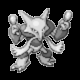

In [1]:
from scipy import misc
from PIL import Image
from io import BytesIO
import IPython.display
import numpy as np

PATH = "resource/alakazam.png"

def display(img):
    f = BytesIO()
    img = np.uint8(img)
    Image.fromarray(img).save(f, 'png')

    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
image = misc.imread(PATH)
image = misc.imresize(image, (80, 80))
image = np.dot(image[:,:,:3], [0.299, 0.587, 0.114])
display(image)

Set Encoder & Decoder

In [2]:
import tensorflow as tf
from functools import reduce
import math

IMAGE_PIXEL_NUM = reduce(lambda a,b: a*b, image.shape)
COMPRESSED_LAYEL_UNIT_NUM = 1000

def encoder(x):
    with tf.name_scope('encoder'):
        W1 = tf.Variable(
            tf.random_normal([IMAGE_PIXEL_NUM, 5000], name='w1')
            )
        b1 = tf.Variable(tf.zeros([5000]),
                        name='b1')
        W2 = tf.nn.dropout(
                tf.Variable(
                    tf.random_normal([5000, 3000], name='w2')
                        ), 0.5)
        b2 = tf.Variable(tf.zeros([3000]),
                        name='b2')
        W3 = tf.nn.dropout(
                tf.Variable(
                    tf.random_normal([3000, COMPRESSED_LAYEL_UNIT_NUM], name='w2')
                ), 0.5)
        b3 = tf.Variable(tf.zeros([COMPRESSED_LAYEL_UNIT_NUM]),
                        name='b2')
    h1 = tf.nn.sigmoid(tf.add(tf.matmul(x, W1), b1))
    h2 = tf.nn.relu(tf.add(tf.matmul(h1, W2), b2))
    return tf.nn.relu(tf.add(tf.matmul(h2, W3), b3))
    
def decoder(x):
    with tf.name_scope('decoder'):
        W1 = tf.Variable(
            tf.random_normal([COMPRESSED_LAYEL_UNIT_NUM, 2000], name='w1')
            )
        b1 = tf.Variable(tf.zeros([2000]),
                        name='b1')
        W2 = tf.nn.dropout(
                tf.Variable(
                    tf.random_normal([2000, 5000], name='w2')
                ), 0.5)
        b2 = tf.Variable(tf.zeros([5000]),
                        name='b2')
        W3 = tf.Variable(
            tf.random_normal([5000, IMAGE_PIXEL_NUM], name='w3')
            )
        b3 = tf.Variable(tf.zeros([IMAGE_PIXEL_NUM]),
                        name='b3')
    h1 = tf.nn.sigmoid(tf.add(tf.matmul(x, W1), b1))
    h2 = tf.nn.sigmoid(tf.add(tf.matmul(h1, W2), b2))
    return tf.nn.relu(tf.add(tf.matmul(h2, W3), b3))

Loss

In [3]:
LEARNING_RATE = 0.5

X = tf.placeholder(tf.float32, shape=(None, IMAGE_PIXEL_NUM))

mid_layer = encoder(X)
Y = decoder(mid_layer)

cost = tf.reduce_mean(tf.pow(X - Y, 2))
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cost)

Train

In [4]:
EPOCHS = 600
DSPLAY_STEP = 50

init = tf.global_variables_initializer()

x = image.reshape(1, IMAGE_PIXEL_NUM)

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    # Training cycle
    for epoch in range(EPOCHS):
        _, c = sess.run([train_step, cost], feed_dict={X: x})
        
        # Display logs per epoch step
        if epoch % DSPLAY_STEP == 0:
            print("Epoch:", '%05d' % (epoch+1), "cost=", "{:.9f}".format(c))

    save_path = saver.save(sess, "./session/AutoEncoder.ckpt")
    print("Optimization Finished!")

Epoch: 00001 cost= 9401.566406250
Epoch: 00051 cost= 1401.043701172
Epoch: 00101 cost= 1271.911254883
Epoch: 00151 cost= 1245.617675781
Epoch: 00201 cost= 1237.725830078
Epoch: 00251 cost= 1229.964721680
Epoch: 00301 cost= 1229.864379883
Epoch: 00351 cost= 1228.321411133
Epoch: 00401 cost= 1225.088012695
Epoch: 00451 cost= 1223.550292969
Epoch: 00501 cost= 1225.707031250
Epoch: 00551 cost= 1222.943237305
Optimization Finished!


In [5]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "./session/AutoEncoder.ckpt")
    target = sess.run(Y, feed_dict={X: x})

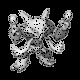

In [6]:
target = target.reshape(80, 80)
display(target)